In [258]:
from pandas import DataFrame, Series
import pandas as pd
import re
from bs4 import BeautifulSoup
from urllib import request
from ast import literal_eval
from datetime import timedelta, datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
credpath = r'C:\Data\Movies\credits.csv'
metadatapath = r'C:\Data\Movies\movies_metadata.csv'
ratingspath = r'C:\Data\Movies\ratings.csv'
credits_raw = pd.read_csv(credpath)
metadata_raw = pd.read_csv(metadatapath)
ratings_raw = pd.read_csv(ratingspath)

C:\Users\Student\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#select only rows of interest
metadata = metadata_raw[['id', 'original_title', 'budget', 'release_date', 'runtime']]
# set date column to datetime
metadata['release_date'] = metadata['release_date'].map(lambda x: pd.to_datetime(x, format='%Y-%m-%d', errors='coerce'))
#get rid of weird .jpg entries for budget and convert to numeric
metadata = metadata[metadata['budget'].map(len) < 20]
metadata['budget'] = metadata['budget'].map(lambda x: pd.to_numeric(x))

C:\Users\Student\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [36]:
#select only rows of interest
credits = credits_raw[['id', 'cast']]
credits['id'] = credits['id'].map(lambda x: str(x))
#convert cast column from string to list of dicts
credits['cast'] = credits['cast'].apply(literal_eval)
#pull out lead actor gender from cast info
credits['gender'] = credits['cast'].map(lambda x: [dictionary['gender'] for dictionary in x if dictionary['order'] == 0])
#female lead flag
credits['female_lead'] = credits['gender'].map(lambda x: 1 if str(x) == '[1]' else 0)

C:\Users\Student\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Student\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [109]:
#join metadata and credits dataframes
credmeta = metadata.join(credits.set_index('id'), on='id')[['id', 'original_title', 'budget', 'release_date', 'runtime','female_lead']]
#filter by movies with non zero budget and female leads
credmeta = credmeta[(credmeta['budget'] != 0) & (credmeta['female_lead'] == 1)]
#calculate cost per minute
credmeta['cost_per_min'] = credmeta['budget']/credmeta['runtime']

In [185]:
ratings = ratings_raw
#convert movieId to str to facilitate joining
ratings['movieId'] = ratings['movieId'].map(lambda x: str(x))
#filter by movies that have female leads and non zero budgets
ratings = ratings[ratings.movieId.isin(list(credmeta.id))]
#bring in release date
ratings = ratings.merge(credmeta, left_on='movieId', right_on='id', how='inner')[['userId', 'rating', 'timestamp', 'id', 'release_date']]
#convert review date to datetime
ratings['review_date'] = ratings['timestamp'].map(lambda x: pd.to_datetime(x, unit='s'))
#get time difference between release and review
ratings['days_since_release'] = ratings['review_date'] - ratings['release_date']
#convert time difference to months
ratings['months_since_release'] = ratings['days_since_release'].astype('timedelta64[M]')


In [221]:
#filter by ratings left in first month
filt_ratings = ratings[ratings['months_since_release'] == 0]

#filter out less than 10 reviews
over10_ratings = filt_ratings.groupby('id').count()[filt_ratings.groupby('id').count()['userId'] >= 10].index
filt_ratings = filt_ratings[filt_ratings['id'].isin(over10_ratings)]

In [222]:
over10_ratings

Index(['1018', '104', '1259', '1279', '1378', '1439', '1562', '1588', '16',
       '1641', '1831', '187', '1951', '1957', '1958', '1969', '1995', '1997',
       '2002', '2011', '2018', '2046', '2171', '2176', '2268', '2288', '2360',
       '24', '2642', '277', '2841', '3037', '316', '334', '350', '3638', '393',
       '39446', '3981', '4248', '431', '4351', '4368', '441', '455', '47518',
       '508', '509', '51540', '540', '544', '546', '553', '55721', '588',
       '590', '597', '637', '664', '6947', '786', '8014', '8966', '8968',
       '924'],
      dtype='object', name='id')

In [223]:
#make average ratings table
avgratings = filt_ratings.groupby('id').mean()[['rating']]
#merge with columns with movie details
final_calc_df = credmeta.merge(avgratings, left_on='id', right_on='id', how='inner')[['id', 'original_title', 'budget', 'runtime', 'cost_per_min', 'rating']]
#ratio of rating:cost per minute * 1000
final_calc_df['rating_cost_ratio'] = final_calc_df['rating'] / final_calc_df['cost_per_min'] *1000

In [228]:
#top 20 based on ratio
top20 = final_calc_df.nlargest(20, 'rating_cost_ratio')

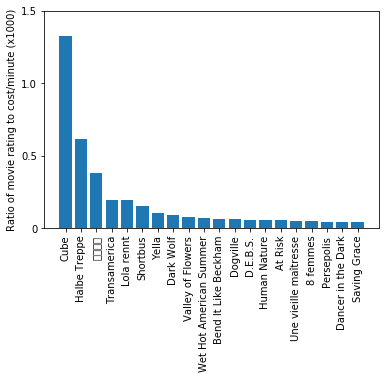

In [257]:

titles = list(top20.original_title)
ratings = list(top20.rating_cost_ratio)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
plt.bar(titles, ratings)
plt.xticks(titles, list(top20.original_title), rotation=90)
plt.yticks([0, 0.5, 1.0, 1.5], [0, 0.5, 1.0, 1.5])
plt.ylabel('Ratio of movie rating to cost/minute (x1000)')
plt.show()

In [261]:
top20.to_pickle('top20movies.pkl')